In [28]:
import os
from os.path import join, dirname, exists
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import torch.optim as optim
import torch.utils.data as data


### Load Data

We will load shapes data and convert the data into binary form i.e. pixel values will either be 1 or zero.

We are using "shapes" dataset which has images across 9 different geometrical shapes. The pickled dataset has images of shape 20x20x1. We convert pixvel values from 0-255 range to {0,1} - i.e. pixel being "off" or "on".


In [29]:
def load_data():
    with open('data/shapes.pkl', 'rb') as f:
        data = pickle.load(f)
    train_data, test_data = data['train'], data['test']
    train_data = (train_data > 127.5).astype('uint8')
    test_data = (test_data > 127.5).astype('uint8')
    return train_data, test_data


### Visualize data

We now load and visualize the data. We have 10479 images of shape 20x20x1 in `train_data` and 4491 images of same shape in `test_data`.

In this we note book we will use train_data images to train a MADE model and then use the trained model to create synthetic images which should look similar to the train images of geometric figures.


In [30]:

def show_samples(samples, nrow=10, title='Samples'):
    """
    samples: numpy array of shape (B x H x W x C)
    """

    # the pickled image is of shape HxWxC
    # make samples shape (B x C x H x W)
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2) 
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    # again cast the image back to HxWxC for plt.imshow to work
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Train Shape: (10479, 20, 20, 1)
Test Shape: (4491, 20, 20, 1)


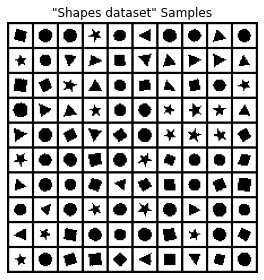

In [31]:
# load data
train_data, test_data = load_data()
name = "Shapes dataset"
print (f'Train Shape: {train_data.shape}')
print (f'Test Shape: {test_data.shape}')

# sample 100 images from train data
idxs = np.random.choice(len(train_data), replace=False, size=(100,))
images = train_data[idxs] * 255

# show 100 samples in a 10x10 grid
show_samples(images, title=f'"{name}" Samples')


### Simple routine to plot the train and test loss curves and to draw some samples from the trained model

In [32]:
def show_training_plot(train_losses, test_losses, title):
    """
    test_losses: one loss value per epoch
    train_losses: one loss value after every batch
    """
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    plt.tight_layout()
    plt.show()



### Code to train the model

In [33]:
def train(model, train_loader, optimizer, epoch, grad_clip=None):
    model.train()
    
    train_losses = []
    for x in train_loader:
        x = x.cuda().contiguous()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda().contiguous()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)

    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        model.train()
        train_losses.extend(train(model, train_loader, optimizer, epoch, grad_clip))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

    return train_losses, test_losses


### MADE network

In [34]:
# Code based one Andrej Karpathy's implementation: https://github.com/karpathy/pytorch-made
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, input_shape, d, hidden_size=[512, 512, 512], 
                ordering=None):
      super().__init__()
      self.input_shape = input_shape
      self.nin = np.prod(input_shape)
      self.nout = self.nin * d
      self.d = d
      self.hidden_sizes = hidden_size
      self.ordering = np.arange(self.nin) if ordering is None else ordering

      # define a simple MLP neural net
      self.net = []
      hs = [self.nin] + self.hidden_sizes + [self.nout]
      for h0, h1 in zip(hs, hs[1:]):
          self.net.extend([
            MaskedLinear(h0, h1),
            nn.ReLU(),
          ])
      self.net.pop()  # pop the last ReLU for the output layer
      self.net = nn.Sequential(*self.net)

      self.m = {}
      self.create_mask()  # builds the initial self.m connectivity

    def create_mask(self):
        L = len(self.hidden_sizes)

        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = self.ordering
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(), 
                                            self.nin - 1, size=self.hidden_sizes[l])

        # construct the mask matrices
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])

        masks[-1] = np.repeat(masks[-1], self.d, axis=1)

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.float()
        x = x.view(batch_size, self.nin)

        logits = self.net(x).view(batch_size, self.nin, self.d)
        return logits.permute(0, 2, 1).contiguous().view(batch_size, self.d, *self.input_shape)

    def loss(self, x):
        return F.cross_entropy(self(x), x.long())

    def sample(self, n):
        samples = torch.zeros(n, self.nin).cuda()
        self.inv_ordering = {x: i for i, x in enumerate(self.ordering)}

        with torch.no_grad():
            for i in range(self.nin):
                logits = self(samples).view(n, self.d, self.nin)[:, :, self.inv_ordering[i]]
                probs = F.softmax(logits, dim=1)
                samples[:, self.inv_ordering[i]] = torch.multinomial(probs, 1).squeeze(-1)

            samples = samples.view(n, *self.input_shape)

        return samples.cpu().numpy()

### Code to run MADE over the Shapes dataset and produce results

In [35]:
def run_made():
    train_data, test_data = load_data()
    H = 20
    W = 20

    # train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    # test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}

    # transpose train and test data for Pytorch
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    model = MADE((1, H, W), 2, hidden_size=[512, 512]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           dict(epochs=20, lr=1e-3))
    samples = model.sample(100)
    samples = np.transpose(samples, (0, 2, 3, 1))

    samples = samples * 255

    show_training_plot(train_losses, test_losses, "Train Test loss Plot")
    show_samples(samples, nrow=10, title='Samples')


Epoch 0, Test loss 0.1763
Epoch 1, Test loss 0.1398
Epoch 2, Test loss 0.1212
Epoch 3, Test loss 0.1099
Epoch 4, Test loss 0.1028
Epoch 5, Test loss 0.0972
Epoch 6, Test loss 0.0911
Epoch 7, Test loss 0.0857
Epoch 8, Test loss 0.0815
Epoch 9, Test loss 0.0789
Epoch 10, Test loss 0.0754
Epoch 11, Test loss 0.0728
Epoch 12, Test loss 0.0716
Epoch 13, Test loss 0.0699
Epoch 14, Test loss 0.0680
Epoch 15, Test loss 0.0668
Epoch 16, Test loss 0.0653
Epoch 17, Test loss 0.0645
Epoch 18, Test loss 0.0631
Epoch 19, Test loss 0.0628


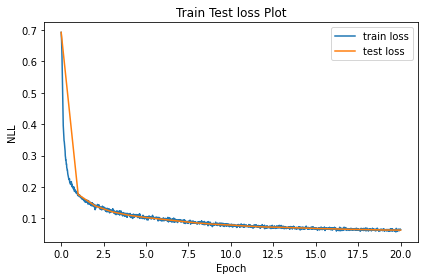

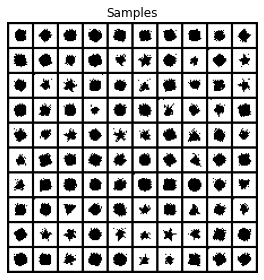

In [36]:
run_made()